# Generative AI Text Summarization

In [106]:
# imports

from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import opendatasets as od
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from openai import OpenAI
import os
from dotenv import load_dotenv
import s3fs
import fs_s3fs
import fsspec
import json
from llama_index.core import TreeIndex, SimpleDirectoryReader
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier
import tensorflow as tf
import keras
import transformers
import mlflow
import hyperopt as hp
import sphinx
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

In [2]:
# download stopwords

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nickr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
pd.set_option('display.max_colwidth', None)

In [4]:
# Download dataset from Kaggle

dataset = "https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset/data"
od.download(dataset)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

Abort: 

In [5]:
# Read dataset, import only 30000 rows of data

df = pd.read_csv(r'C:\Users\nickr\OneDrive\Documents\GitHub\generative-ai-text-summarization\data\ag-news-classification-dataset\ag_news.csv',nrows=30000)

In [6]:
df.shape

(30000, 3)

In [7]:
df['Class Index']=df['Class Index'].astype('category') # Change Class Index to categorical variable

In [8]:
df.head(8) # Confirm importation

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again."
1,3,Carlyle Looks Toward Commercial Aerospace (Reuters),"Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market."
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.
3,3,Iraq Halts Oil Exports from Main Southern Pipeline (Reuters),"Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday."
4,3,"Oil prices soar to all-time record, posing new menace to US economy (AFP)","AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections."
5,3,"Stocks End Up, But Near Year Lows (Reuters)","Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)"
6,3,Money Funds Fell in Latest Week (AP),"AP - Assets of the nation's retail money market mutual funds fell by #36;1.17 billion in the latest week to #36;849.98 trillion, the Investment Company Institute said Thursday."
7,3,Fed minutes show dissent over inflation (USATODAY.com),"USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump."


In [149]:
df.dtypes

Class Index        category
Title                object
Description          object
document_length       int64
title_length          int64
dtype: object

# Data Cleaning and Preprocessing

In [9]:
# find null values and datatypes

df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Class Index  30000 non-null  category
 1   Title        30000 non-null  object  
 2   Description  30000 non-null  object  
dtypes: category(1), object(2)
memory usage: 10.1 MB


There are no null values in the df_train dataset.

In [10]:
# check for duplicates

df.duplicated().sum()

0

There are no duplicate values in the df_train dataset.

In [11]:
# Cleaning data set html, special, and non-textual characters

def cleaning_text(text):
    # Remove HTML tags
    cleaning_text = re.sub('<.*?>', '', text)
    # Remove special characters and non-textual 
    cleaning_text = re.sub(r'([^a-zA-Z\s]|\\b[A-Za-z] \\b|\\b [A-Za-z]\\b)', ' ', cleaning_text) # checks plain text for given characters
    return cleaning_text

In [12]:
# apply text cleaning to text in both Description and Title

df['Title'] = df['Title'].apply(cleaning_text)

In [13]:
df.head(7)

,Class Index,Title,Description
0,3,Wall St Bears Claw Back Into the Black Reuters,"Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again."
1,3,Carlyle Looks Toward Commercial Aerospace Reuters,"Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market."
2,3,Oil and Economy Cloud Stocks Outlook Reuters,Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.
3,3,Iraq Halts Oil Exports from Main Southern Pipeline Reuters,"Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday."
4,3,Oil prices soar to all time record posing new menace to US economy AFP,"AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections."
5,3,Stocks End Up But Near Year Lows Reuters,"Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)"
6,3,Money Funds Fell in Latest Week AP,"AP - Assets of the nation's retail money market mutual funds fell by #36;1.17 billion in the latest week to #36;849.98 trillion, the Investment Company Institute said Thursday."


In [14]:
# Create a function to remove stop words

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = word_tokenize(text.lower())  # Tokenization and lowercasing
    tokens = [word for word in tokens if word not in stop_words]  # Stop word removal
    return ' '.join(tokens)

In [15]:
# apply preprocessing to text in both Description and Title

df['Title'] = df['Title'].apply(preprocess_text)

In [16]:
df.head(7)

,Class Index,Title,Description
0,3,wall st bears claw back black reuters,"Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again."
1,3,carlyle looks toward commercial aerospace reuters,"Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market."
2,3,oil economy cloud stocks outlook reuters,Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.
3,3,iraq halts oil exports main southern pipeline reuters,"Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday."
4,3,oil prices soar time record posing new menace us economy afp,"AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections."
5,3,stocks end near year lows reuters,"Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)"
6,3,money funds fell latest week ap,"AP - Assets of the nation's retail money market mutual funds fell by #36;1.17 billion in the latest week to #36;849.98 trillion, the Investment Company Institute said Thursday."


In [ ]:
# convert to CSV for ease of use in future

cleaned_data_file = r'C:\Users\nickr\OneDrive\Desktop\CapstoneTechX\ag_news_cleaned\cleaned_ag_news.csv'
df.to_csv(cleaned_data_file, index=False)

# Data Splitting

In [17]:
# Split training data into training and validation data 

df_train, df_test = train_test_split(df, test_size=.15, random_state=42)

In [ ]:
# Create csv file for train and test data

df_train.to_csv(os.path.join(r'C:\Users\nickr\OneDrive\Desktop\CapstoneTechX\ag_news_cleaned', 'train.csv'), index=False)
df_test.to_csv(os.path.join(r'C:\Users\nickr\OneDrive\Desktop\CapstoneTechX\ag_news_cleaned', 'test.csv'), index=False)

In [ ]:
# Create feature data directory

feature_data_dir = r'C:\Users\nickr\OneDrive\Desktop\CapstoneTechX\features'
os.makedirs(feature_data_dir, exist_ok=True)

In [96]:
# TF-IDF Vectorization for Title

tfidf_vectorizer = TfidfVectorizer(max_features=3000)  # we can play around with this. This was an arbitrary value
train_title_features = tfidf_vectorizer.fit_transform(df_train['Title'])
test_title_features = tfidf_vectorizer.transform(df_test['Title'])

In [97]:
train_title_features

<25500x3000 sparse matrix of type '<class 'numpy.float64'>'
	with 106909 stored elements in Compressed Sparse Row format>

In [98]:
# look at one of the matrices the vectorizer produces

# print(df_train['Title'][98])
# print(train_title_features.toarray()[98]) 

In [99]:
# Print our features

features = tfidf_vectorizer.get_feature_names_out()
print(tfidf_vectorizer.vocabulary_, end=' ')

{'tennis': 2664, 'agassi': 38, 'goes': 1102, 'google': 1110, 'still': 2545, 'last': 1449, 'digital': 713, 'radio': 2084, 'new': 1734, 'front': 1043, 'piracy': 1913, 'war': 2892, 'ap': 103, 'sony': 2472, 'group': 1130, 'agrees': 45, 'buy': 355, 'mgm': 1616, 'toys': 2730, 'wireless': 2946, 'crowd': 612, 'join': 1378, 'nikkei': 1746, 'average': 176, 'update': 2807, 'nd': 1716, 'shows': 2401, 'request': 2172, 'issue': 1350, 'drops': 771, 'israel': 1347, 'build': 345, 'housing': 1242, 'units': 2801, 'profits': 2023, 'rise': 2212, 'retail': 2186, 'un': 2792, 'staff': 2515, 'call': 366, 'afghan': 32, 'pullout': 2045, 'singh': 2422, 'could': 581, 'woods': 2957, 'chechen': 448, 'story': 2556, 'leader': 1467, 'terror': 2666, 'russia': 2255, 'woodward': 2958, 'lions': 1507, 'coach': 508, 'internet': 1322, 'turns': 2778, 'work': 2961, 'progress': 2026, 'taken': 2634, 'along': 70, 'issues': 1351, 'finally': 952, 'comes': 525, 'age': 39, 'athens': 154, 'van': 2835, 'continues': 565, 'cassini': 408, 

In [72]:
print(len(features))

1000


Note, the vectorizer produces a value for a specific word on a scale of 0 to 1. The closer the number is to 1, the more unique that word is.

In [73]:
# Save the TF-IDF feature matrices

pd.DataFrame(train_desc_features.toarray()).to_csv(os.path.join(feature_data_dir, 'train_desc_features.csv'), index=False)
pd.DataFrame(test_desc_features.toarray()).to_csv(os.path.join(feature_data_dir, 'test_desc_featuress.csv'), index=False)
pd.DataFrame(train_title_features.toarray()).to_csv(os.path.join(feature_data_dir, 'train_title_features.csv'), index=False)
pd.DataFrame(test_title_features.toarray()).to_csv(os.path.join(feature_data_dir, 'test_title_featuress.csv'), index=False)

NameError: name 'train_desc_features' is not defined

# EDA

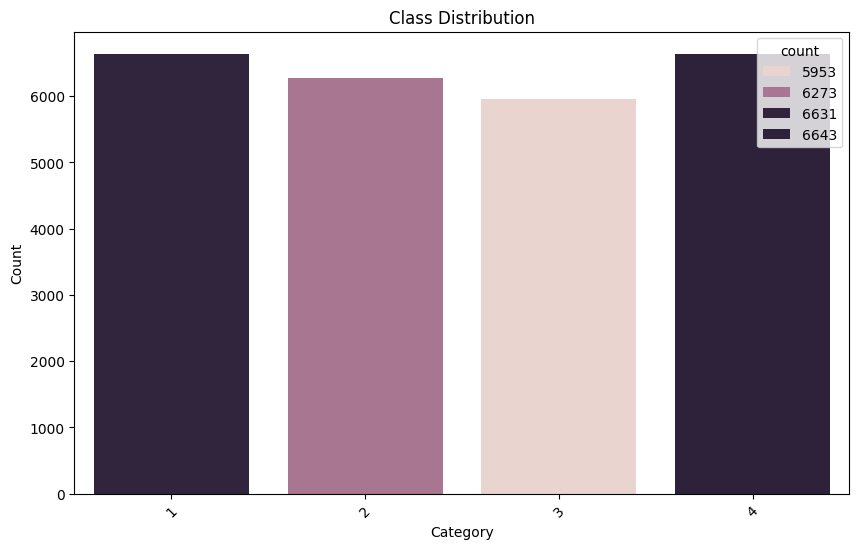

In [74]:
# Sum the counts of each index
class_counts = df_train['Class Index'].value_counts().reset_index()

# Visualize class distribution
plt.figure(figsize=(10, 6))
sns.barplot(data=class_counts, x='Class Index', y='count', hue='count')
plt.title('Class Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [75]:
# Summary statistics of class distribution

class_balance = class_counts.describe()
print("Class Balance:")
print(class_balance)

Class Balance:
             count
count     4.000000
mean   6375.000000
std     329.569416
min    5953.000000
25%    6193.000000
50%    6452.000000
75%    6634.000000
max    6643.000000


Note that there is a fair even distribution of categories in our training dataset. No further resampling techniques needed.

In [158]:
# Debugging Word Frequence Analysis

class_filter = df['Class Index'] == 1
df_filter = df[class_filter]

In [185]:
# Word Frequency Analysis

for index in range(len(df['Class Index'])):
    if index == 1:
        index_list_one = ' '.join(df.iloc[index,1]).split()
        word_counts_one = Counter(index_list_one)
    elif index == 2:
        index_list_two = ' '.join(df.iloc[index,1]).split()
        word_counts_two = Counter(index_list_two)
    elif index == 3:
        index_list_three = ' '.join(df.iloc[index,1]).split()
        word_counts_three = Counter(index_list_three)
    elif index == 4:
        index_list_four = ' '.join(df.iloc[index,1]).split()
        word_counts_four = Counter(index_list_four)
        
one_common_words = word_counts_one.most_common(30)
two_common_words = word_counts_two.most_common(30)
three_common_words = word_counts_three.most_common(30)
four_common_words = word_counts_four.most_common(30)

print("\nIndex One - Most Common Words:")
print(one_common_words)
print("\nIndex Two - Most Common Words:")
print(two_common_words)
print("\nIndex Three - Most Common Words:")
print(three_common_words)
print("\nIndex Four - Most Common Words:")
print(four_common_words)
    


Index One - Most Common Words:
[('r', 6), ('e', 6), ('a', 5), ('o', 5), ('c', 4), ('l', 4), ('s', 3), ('t', 2), ('m', 2), ('y', 1), ('k', 1), ('w', 1), ('d', 1), ('i', 1), ('p', 1), ('u', 1)]

Index Two - Most Common Words:
[('o', 8), ('l', 3), ('e', 3), ('c', 3), ('u', 3), ('s', 3), ('t', 3), ('k', 2), ('r', 2), ('i', 1), ('n', 1), ('m', 1), ('y', 1), ('d', 1)]

Index Three - Most Common Words:
[('e', 6), ('i', 5), ('r', 5), ('t', 4), ('s', 4), ('a', 3), ('l', 3), ('o', 3), ('p', 3), ('n', 3), ('h', 2), ('u', 2), ('q', 1), ('x', 1), ('m', 1)]

Index Four - Most Common Words:
[('e', 7), ('o', 6), ('i', 4), ('r', 4), ('c', 4), ('s', 4), ('n', 4), ('p', 3), ('a', 3), ('m', 3), ('l', 1), ('t', 1), ('d', 1), ('g', 1), ('w', 1), ('u', 1), ('y', 1), ('f', 1)]


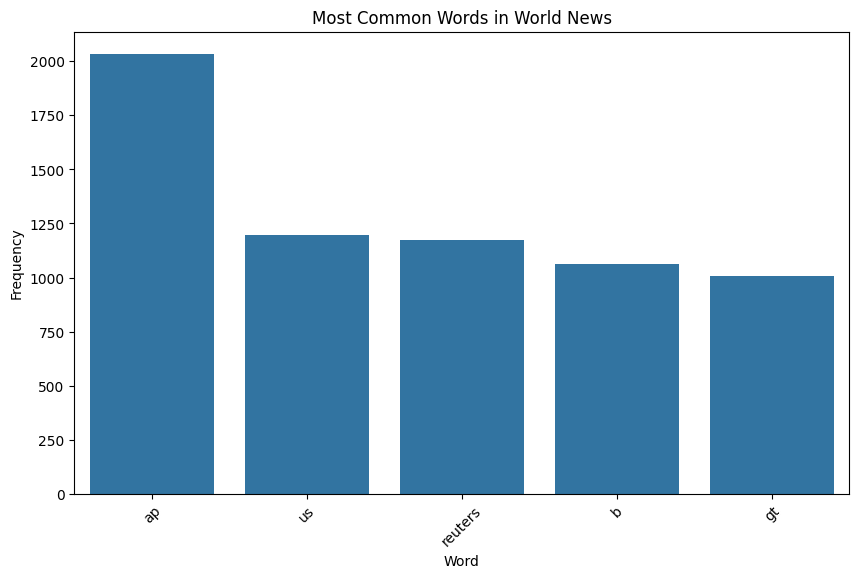

In [157]:
# Vizualize word frequence

plt.figure(figsize=(10, 6))
sns.barplot(x=[word[0] for word in one_common_words], y=[word[1] for word in one_common_words])
plt.title('Most Common Words in World News')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [126]:
# Get title lengths for each row

df_train['title_length'] = df_train['Title'].apply(lambda x: len(x.split()))
print(df['title_length'])

# Modifying df_test for future use
df_test['title_length'] = df_test['Title'].apply(lambda x: len(x.split()))

0         7
1         6
2         6
3         8
4        11
         ..
29995     7
29996     8
29997     7
29998     6
29999     2
Name: title_length, Length: 30000, dtype: int64


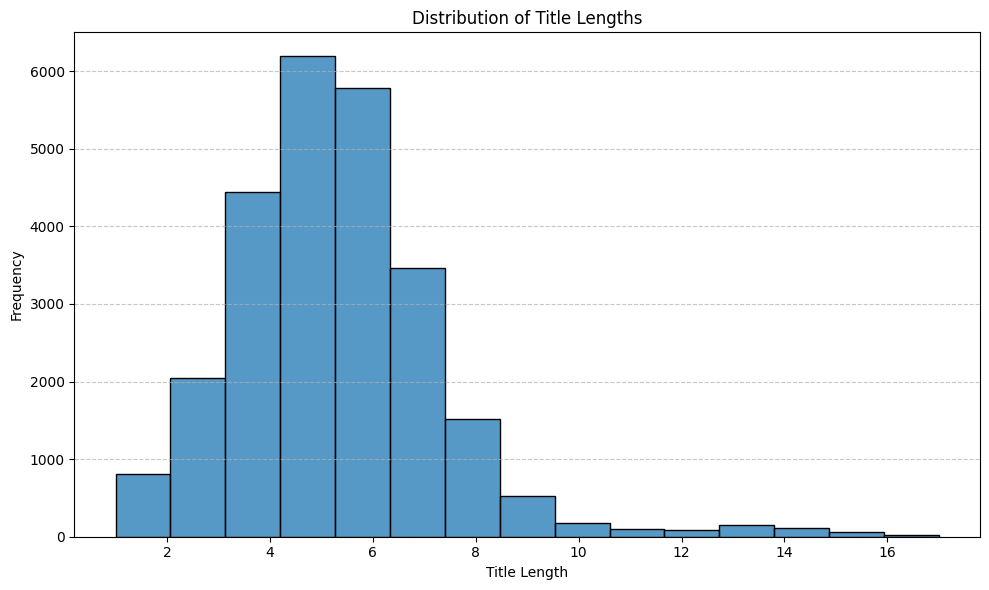

In [80]:
# Title length analysis

plt.figure(figsize=(10, 6))
sns.histplot(df_train['title_length'], bins=15)
plt.title('Distribution of Title Lengths')
plt.xlabel('Title Length')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

Note that the distribution of our title lengths is right-skew

In [100]:
tfidf_df = pd.DataFrame(train_title_features.toarray())

In [101]:
tfidf_df

,0,1,2,3,4,5,6,7,8,9,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [113]:
# Transform matrix to array, flatten, and removes zeros

tfidf_df = train_title_features.toarray().flatten()
tfidf_df = tfidf_df[tfidf_df != 0]

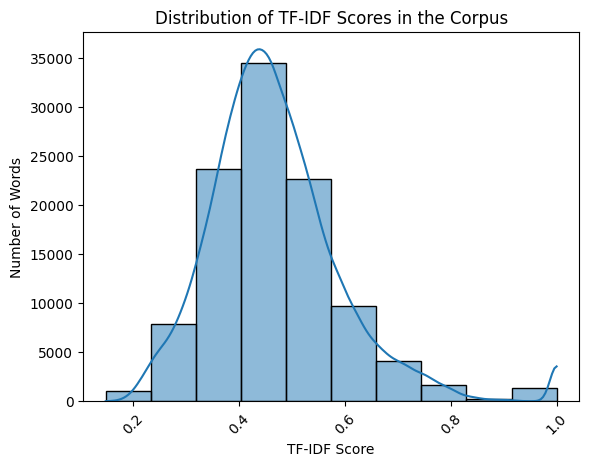

In [119]:
# Distribution of non-zero TF-IDF Scores

sns.histplot(tfidf_df, bins=10, kde=True)
plt.xlabel("TF-IDF Score")
plt.ylabel("Number of Words")
plt.title("Distribution of TF-IDF Scores in the Corpus")
plt.xticks(rotation=45)  # Optional: Rotate x-axis labels for long feature names
plt.show()

Note that our TF IDF distribution is right skew

In [122]:
from feature_engine.outliers import Winsorizer
from scipy.stats import mstats

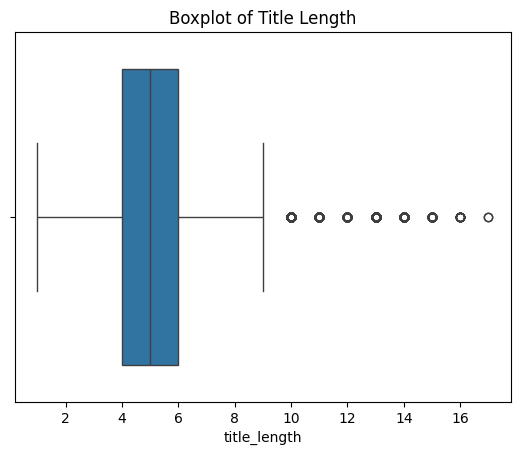

In [135]:
# Plot boxplot to find skewness

sns.boxplot(df_train['title_length'], orient='h')
plt.xlabel("title_length")
plt.title("Boxplot of Title Length")  # Optional: Rotate x-axis labels for long feature names
plt.show()

Confirms previous image indicating right skewness

In [123]:
# Winsorize the text length to handle outliers

capper = Winsorizer(capping_method='gaussian', tail='right', fold=2)
capper.fit(df_train)

Winsorizer(fold=2)

In [124]:
capper.right_tail_caps_

{'title_length': 9.395161382764899}

In [127]:
train_t = capper.transform(df_train)
test_t = capper.transform(df_test)

In [ ]:
sns.boxplot(train_t['title_length'], orient='h')
plt.xlabel("title_length")
plt.title("Boxplot of Title Length")  # Optional: Rotate x-axis labels for long feature names
plt.show()